# Visualizing the attention in a multi modal LLM

## CLIP

### Model showcase

/Users/i551965/Library/Caches/pypoetry/virtualenvs/deeplearning_bs-Vefx44GI-py3.12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


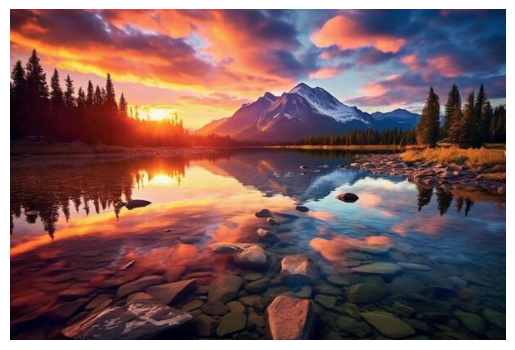

Probability distribution over the texts:
a tree: 0.51 %
a dog: 0.02 %
green grass: 3.27 %
a lake: 96.20 %


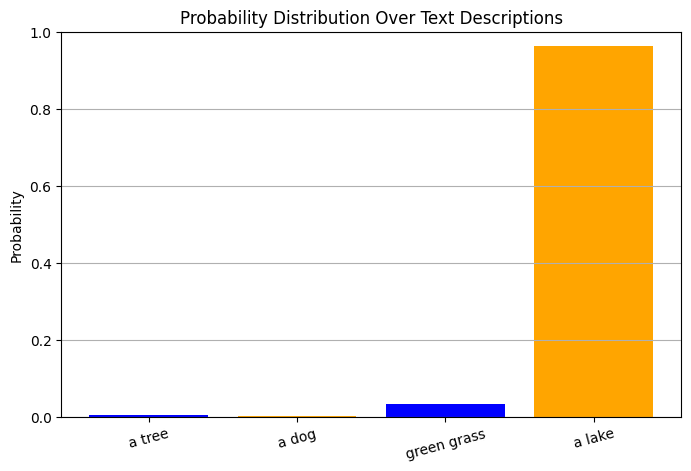

The most probable description is: a lake


In [9]:
from PIL import Image, ImageDraw, ImageFont
import requests
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from transformers import CLIPProcessor, CLIPModel

# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load the image from a URL
url = "https://static.vecteezy.com/system/resources/thumbnails/025/181/412/small_2x/picture-a-captivating-scene-of-a-tranquil-lake-at-sunset-ai-generative-photo.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# Define the text descriptions
texts = ["a tree", "a dog", "green grass", "a lake"]

# Process the inputs
inputs = processor(text=texts, images=image, return_tensors="pt", padding=True)

model.eval()
with torch.no_grad():
    outputs = model(**inputs)

# Forward pass through the model
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # Image-text similarity scores
probs = logits_per_image.softmax(dim=1)  # Softmax to get probabilities

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

# Print the probability distribution over the texts
print("Probability distribution over the texts:")
for text, prob in zip(texts, probs[0]):
    print(f"{text}: {prob.item()*100:.2f} %")

# Create a bar chart for the probabilities
plt.figure(figsize=(8, 5))
plt.bar(texts, probs[0].detach().numpy(), color=['blue', 'orange'])
plt.ylabel('Probability')
plt.title('Probability Distribution Over Text Descriptions')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.xticks(rotation=15)  # Rotate x-axis labels for better visibility
plt.grid(axis='y')  # Add grid lines for better readability
plt.show()

# Find and print the most probable description
most_probable_description = texts[torch.argmax(probs)]
print(f"The most probable description is: {most_probable_description}")

### Model Analysis
The clip model consists mainly of a text model and a vision model. The text model produces embeddings for the text and the image model produces embeddings for the image. These embeddings should be close together if the textual description matches the content of the picture and not if otherwise. The comparison happens using the cosine similarity in the CLIPModel file (line 1330).

In [10]:
model

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

### Text Model

In [11]:
print(model.text_model)

CLIPTextTransformer(
  (embeddings): CLIPTextEmbeddings(
    (token_embedding): Embedding(49408, 512)
    (position_embedding): Embedding(77, 512)
  )
  (encoder): CLIPEncoder(
    (layers): ModuleList(
      (0-11): 12 x CLIPEncoderLayer(
        (self_attn): CLIPSdpaAttention(
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): CLIPMLP(
          (activation_fn): QuickGELUActivation()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (layer_norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (final_layer_norm

### Vision model
CLIP commonly uses ViT as the image transformer. So does this example, as can be seen in the model name: openai/clip-**vit**-base-patch32. ViT was introduced in this paper https://arxiv.org/abs/2010.11929 and bascially applies the transformer architecture, which was previously mostly used for NLP tasks successfully to image classification tasks.

The size of the image is: 224 times 224.
The patch size of the ViT is: 32.
This results in a total number of 49 patches.


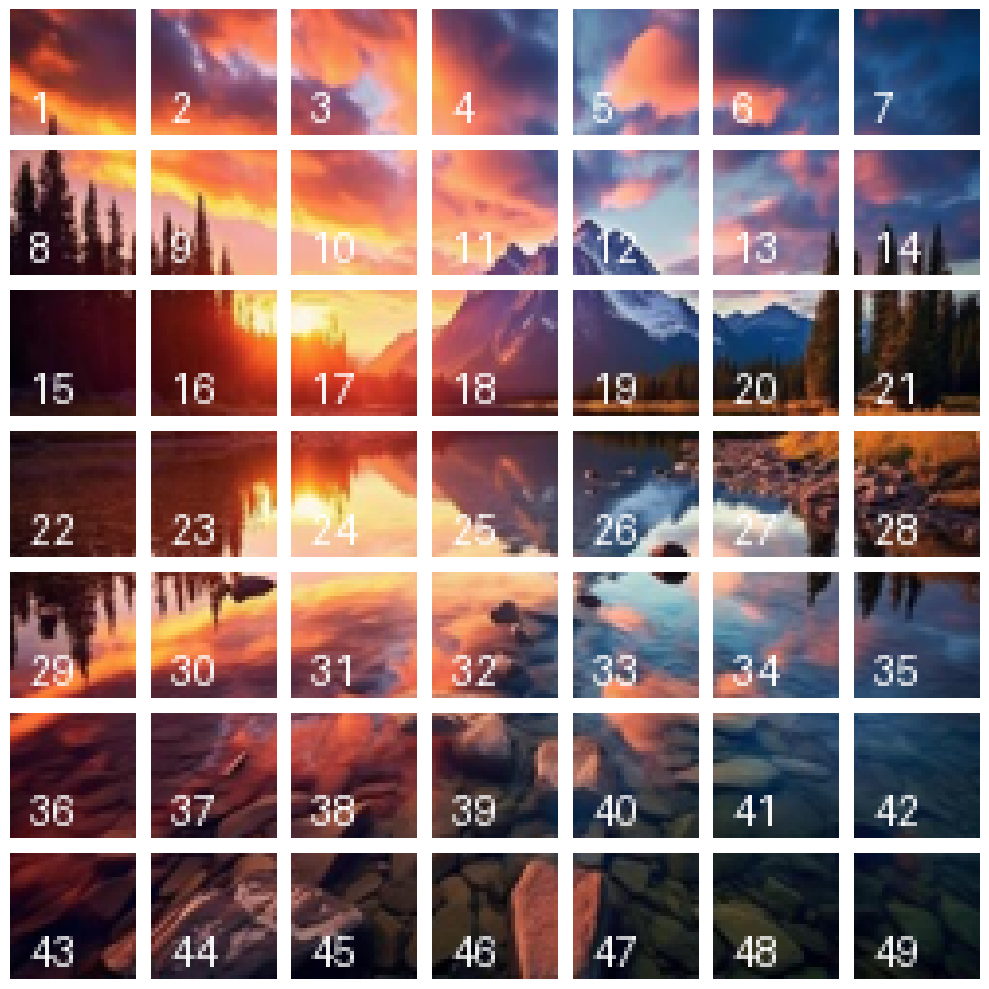

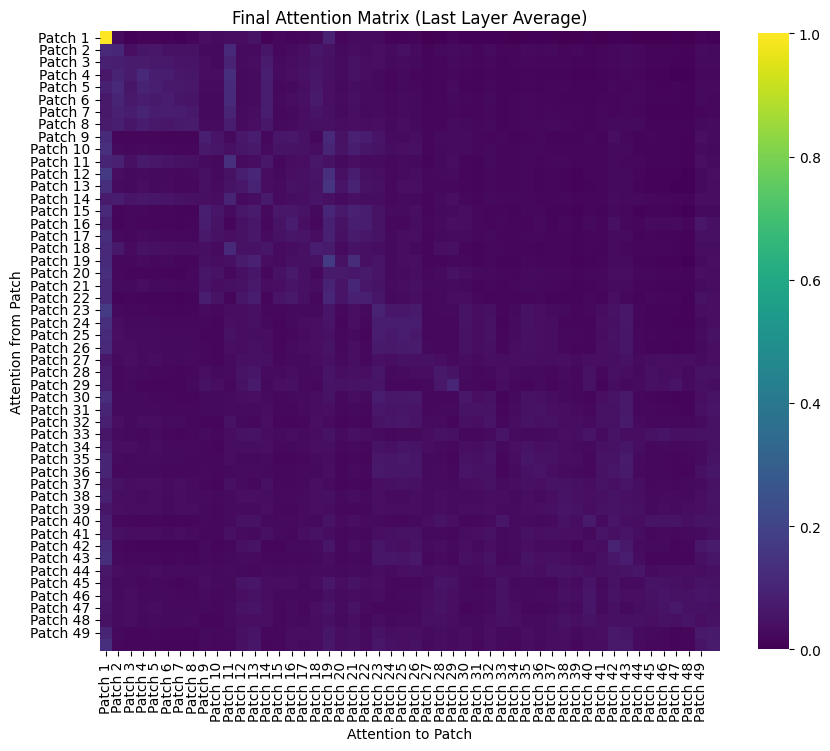

[ 618  918  550 1100    0] [47 45 33 26 37]


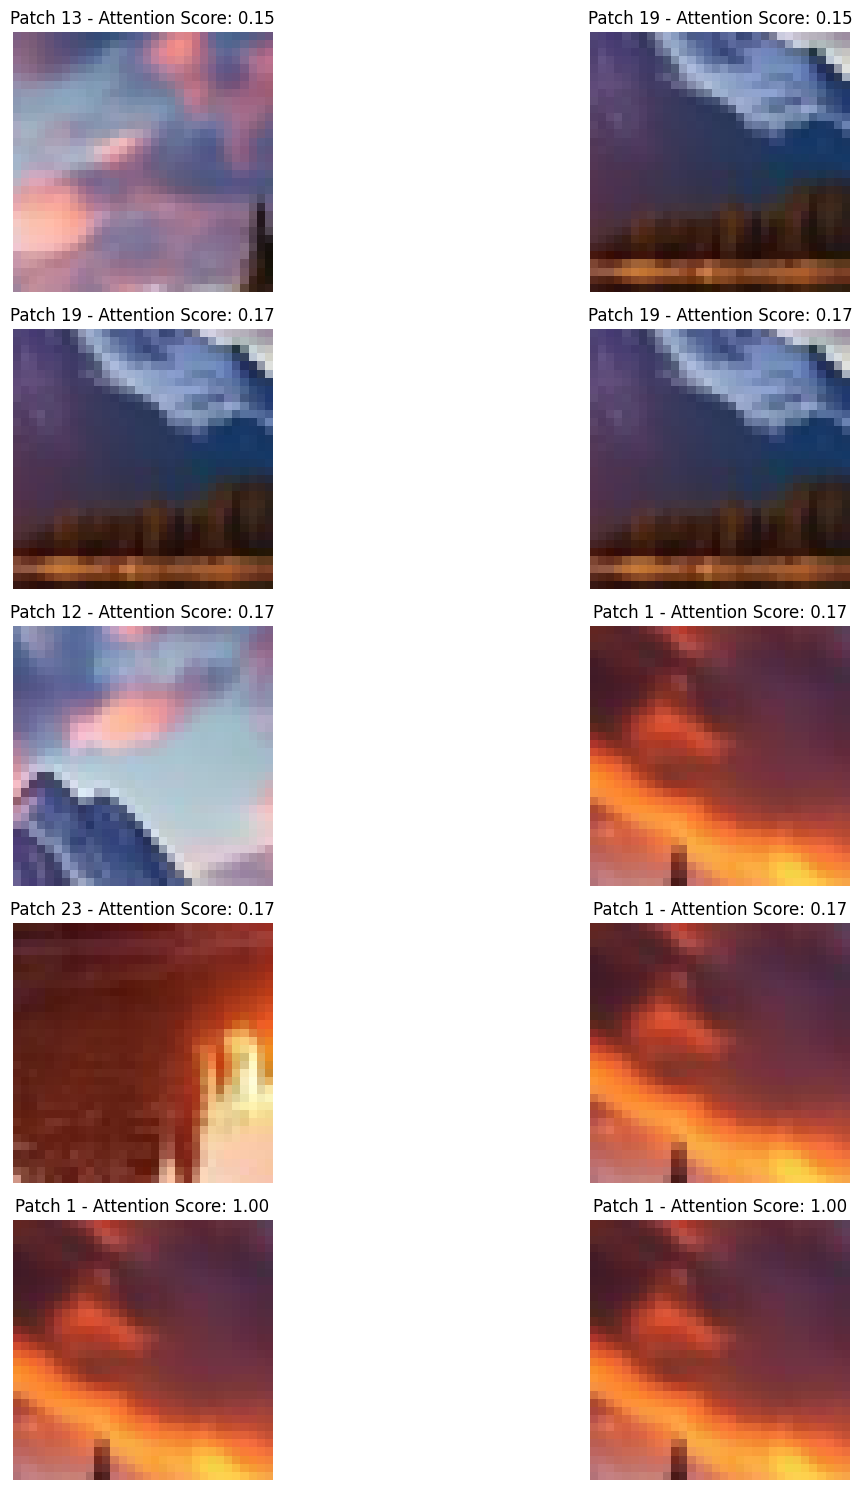

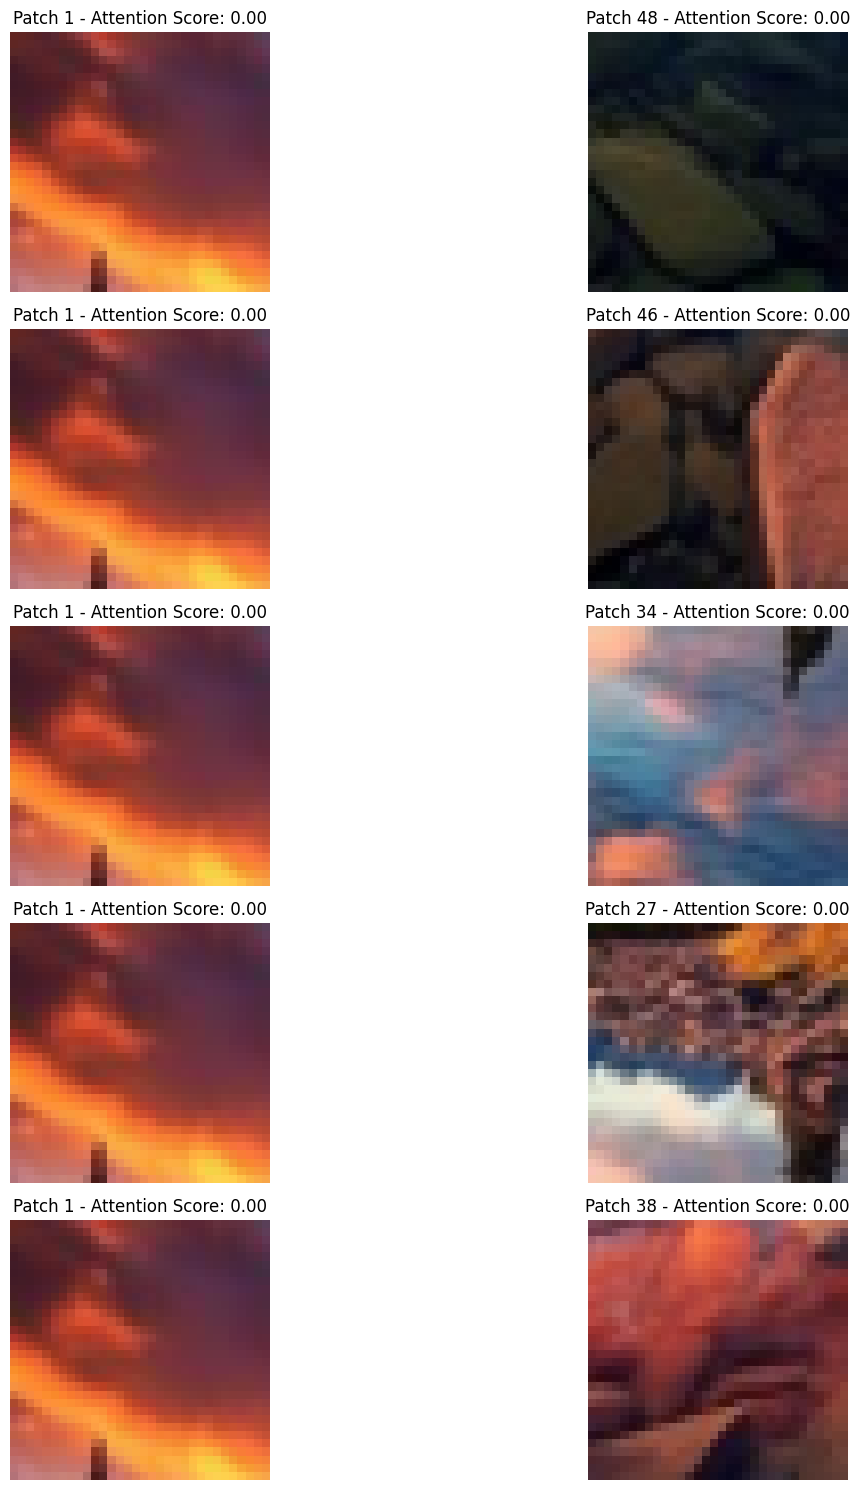

In [14]:
image = image.resize((224, 224))

# Process the inputs for the image only (no text for this part)
inputs = processor(images=image, return_tensors="pt", padding=True)

# Get the processed image size
image_size = inputs['pixel_values'].shape[-2:]
print(f"The size of the image is: {image_size[0]} times {image_size[1]}.")

# Get the model's vision configuration (this contains the patch size)
vision_config = model.vision_model.config
patch_size = vision_config.patch_size
print(f"The patch size of the ViT is: {patch_size}.")

# Calculate the number of patches
num_patches_height = image_size[0] // patch_size
num_patches_width = image_size[1] // patch_size
total_patches = num_patches_height * num_patches_width
print(f"This results in a total number of {total_patches} patches.")

# Extract attention weights from the image encoder (ViT)
def get_attention_weights(model, inputs):
    # Forward pass through the image encoder
    outputs = model.vision_model(**inputs, output_attentions=True)
    attentions = outputs.attentions  # Extract attention from all layers
    return attentions

# Get attention weights for the image
model.eval()
with torch.no_grad():
    attentions = get_attention_weights(model, inputs)

# Now, let's extract and visualize each patch
# Create a new figure for displaying patches
plt.figure(figsize=(10, 10))

# Loop over the patches and display them
patch_count = 1
for i in range(num_patches_height):
    for j in range(num_patches_width):
        # Calculate the left, upper, right, and lower coordinates for the patch
        left = j * patch_size
        upper = i * patch_size
        right = left + patch_size
        lower = upper + patch_size

        # Extract the patch from the original image
        patch = image.crop((left, upper, right, lower))

        # Create a new image to draw the patch number
        draw_patch = patch.copy()
        draw = ImageDraw.Draw(draw_patch)
        
        # Define the patch number text
        patch_number_text = f"{patch_count}"
        
        # Choose a font and size
        font_size = 12  # Adjust font size as needed
        font = ImageFont.load_default()  # Use default font
        
        # Use textbbox to find the size of the text
        bbox = draw.textbbox((0, 0), patch_number_text, font=font)
        text_width = bbox[2] - bbox[0]  # width = right - left
        text_height = bbox[3] - bbox[1]  # height = bottom - top
        
        # Draw the patch number in the bottom left corner
        draw.text((5, patch.size[1] - text_height - 5), patch_number_text, fill="white", font=font)

        # Display each patch in a subplot
        plt.subplot(num_patches_height, num_patches_width, patch_count)
        plt.imshow(draw_patch)
        plt.axis('off')
        patch_count += 1

plt.tight_layout()
plt.show()

# Select the attention weights from the last layer
attention_weights_last_layer = attentions[-1]

# Average attention across all heads in the last layer
final_attention_matrix = attention_weights_last_layer.mean(dim=1)[0].cpu().numpy()  # Shape: [num_patches, num_patches]

# Normalize the final attention matrix (optional)
final_attention_matrix = (final_attention_matrix - np.min(final_attention_matrix)) / (np.max(final_attention_matrix) - np.min(final_attention_matrix))

# Create a heatmap to visualize the final attention matrix
plt.figure(figsize=(10, 10))
sns.heatmap(final_attention_matrix, cmap='viridis', square=True, cbar_kws={"shrink": .8},
            xticklabels=[f'Patch {i+1}' for i in range(num_patches_height * num_patches_width)],
            yticklabels=[f'Patch {i+1}' for i in range(num_patches_height * num_patches_width)])
plt.title(f'Final Attention Matrix (Last Layer Average)')
plt.xlabel('Attention to Patch')
plt.ylabel('Attention from Patch')

# Show the final attention plot
plt.show()

# Find the indices of the highest and lowest attention score pairs
top_k = 5
flat_attention_matrix = final_attention_matrix.flatten()
top_indices = np.argsort(flat_attention_matrix)[-top_k:]
bottom_indices = np.argsort(flat_attention_matrix)[:top_k]
print(top_indices, bottom_indices)

# Create a list of tuples (patch_1_idx, patch_2_idx, attention_score)
top_pairs = [(np.unravel_index(idx, final_attention_matrix.shape), flat_attention_matrix[idx]) for idx in top_indices]
bottom_pairs = [(np.unravel_index(idx, final_attention_matrix.shape), flat_attention_matrix[idx]) for idx in bottom_indices]

def plot_image_pairs(pairs):
    # Display the pairs of patches with the highest attention scores
    plt.figure(figsize=(15, 15))
    for i, (indices, score) in enumerate(pairs):
        patch1_idx, patch2_idx = indices
        left1, upper1 = (patch1_idx % num_patches_width) * patch_size, (patch1_idx // num_patches_width) * patch_size
        right1, lower1 = left1 + patch_size, upper1 + patch_size
        left2, upper2 = (patch2_idx % num_patches_width) * patch_size, (patch2_idx // num_patches_width) * patch_size
        right2, lower2 = left2 + patch_size, upper2 + patch_size

        # Extract the patches from the original image
        patch1 = image.crop((left1, upper1, right1, lower1))
        patch2 = image.crop((left2, upper2, right2, lower2))

        # Display the patches
        plt.subplot(top_k, 2, i * 2 + 1)
        plt.imshow(patch1)
        plt.axis('off')
        plt.title(f'Patch {patch1_idx+1} - Attention Score: {score:.2f}')

        plt.subplot(top_k, 2, i * 2 + 2)
        plt.imshow(patch2)
        plt.axis('off')
        plt.title(f'Patch {patch2_idx+1} - Attention Score: {score:.2f}')

    plt.tight_layout()
    plt.show()

plot_image_pairs(top_pairs)
plot_image_pairs(bottom_pairs)

### Plot a heatmap visualizing attention over the image

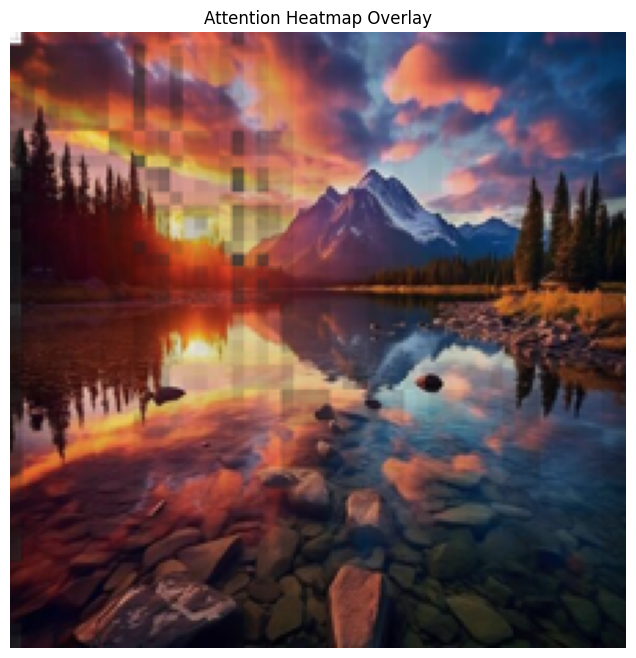

In [29]:
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

# Create attention heatmap overlaid on the original image
def plot_attention_heatmap_on_image(image, attention_matrix, num_patches_height, num_patches_width, patch_size):
    # Create a blank image to overlay the heatmap
    heatmap = np.zeros((num_patches_height * patch_size, num_patches_width * patch_size))
    heatmap = np.clip(heatmap ** 2, 0, 1)  # Square to enhance higher attention values

    # Reshape the attention matrix into the corresponding patch grid
    attention_reshaped = attention_matrix.reshape((num_patches_height, num_patches_width))

    # Loop through each patch, and fill the corresponding area in the heatmap
    for i in range(num_patches_height):
        for j in range(num_patches_width):
            heatmap[i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size] = attention_reshaped[i, j]

    # Normalize the heatmap values to the range [0, 1]
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

    # Resize the heatmap to match the original image size
    heatmap_resized = Image.fromarray(np.uint8(heatmap * 255)).resize(image.size, Image.LANCZOS)

    # Convert the heatmap to RGBA for transparency
    heatmap_resized = heatmap_resized.convert("RGBA")

    # Adjust the transparency of the heatmap (alpha channel)
    heatmap_array = np.array(heatmap_resized)
    heatmap_array[..., 3] = (np.array(heatmap_resized)[:, :, 0] * 5).astype(np.uint8)


    # Overlay the heatmap onto the original image
    overlay_image = Image.alpha_composite(image.convert('RGBA'), Image.fromarray(heatmap_array))

    # Display the image with attention heatmap
    plt.figure(figsize=(8, 8))
    plt.imshow(overlay_image)
    plt.axis('off')
    plt.title("Attention Heatmap Overlay")
    plt.show()

# Normalize and use the average attention matrix from the last layer
final_attention_matrix = (final_attention_matrix - np.min(final_attention_matrix)) / (np.max(final_attention_matrix) - np.min(final_attention_matrix))

# Call the function to overlay the attention heatmap on the image
plot_attention_heatmap_on_image(image, final_attention_matrix, total_patches+1, total_patches+1, patch_size)